In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from IPython.core.display import HTML
import shutil


dropout_rate = 0.7
DATA_DIR = f'results_007_gn_lang_classification_contrastive'



random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#7f7f7f", "#1f77b4"]

n = 84
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
data_frames = {}

variable_names = []

for model_path in Path(DATA_DIR).iterdir():
    if not model_path.is_dir():
        continue
        
    if "NN" not in str(model_path):
        continue
    
    model_name = model_path.stem
    print(f"MODEL: {model_name}")
    fold_names = []
    
    data_frames[model_name] = {}
    
    for p in Path(model_path).iterdir():
        if not p.suffixes or p.suffixes[-1] != '.csv':
            continue
        fold_name = p.stem
        fold_names.append(fold_name)
        data_frames[model_name][fold_name] = pd.read_csv(p)
        variable_names.extend(list(data_frames[model_path.stem][p.stem].columns))
    for fold_name in sorted(fold_names):
        print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
        
    

MODEL: LangIdCNN_Mean3
	retrained-wav2vec_features-c_0
	retrained-wav2vec_features-c_1
	retrained-wav2vec_features-c_2
	retrained-wav2vec_features-c_3
	retrained-wav2vec_features-c_4
	retrained-wav2vec_features-c_5
	retrained-wav2vec_features-c_6
	retrained-wav2vec_features-c_7
	retrained-wav2vec_features-c_8
	retrained-wav2vec_features-c_9
	retrained-wav2vec_features-z_0
	retrained-wav2vec_features-z_1
	retrained-wav2vec_features-z_2
	retrained-wav2vec_features-z_3
	retrained-wav2vec_features-z_4
	retrained-wav2vec_features-z_5
	retrained-wav2vec_features-z_6
	retrained-wav2vec_features-z_7
	retrained-wav2vec_features-z_8
	retrained-wav2vec_features-z_9
	wav2vec_features-c_0
	wav2vec_features-c_1
	wav2vec_features-c_2
	wav2vec_features-c_3
	wav2vec_features-c_4
	wav2vec_features-c_5
	wav2vec_features-c_6
	wav2vec_features-c_7
	wav2vec_features-c_8
	wav2vec_features-c_9
	wav2vec_features-z_0
	wav2vec_features-z_1
	wav2vec_features-z_2
	wav2vec_features-z_3
	wav2vec_features-z_4
	wav2ve

In [3]:
def get_variable_stats(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum
    
        

In [4]:
def get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    for index, df in enumerate(selected_dfs):
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    return ep_best

def get_variable_stats(model_name, feature_prefix, variable, sample_size, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    #best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        #best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    #ep_best = np.argmax(best_epoch_selection_data, axis=0)
    ep_best = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [5]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable, sample_size):
    line_styles = ['-', '-']
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle=line_styles[index], label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [6]:
def plot_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}

    plot_width = len(model_names)*10
    plot_height = len(variables)*10
    fig, axes = plt.subplots(len(variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    for variable_index, variable in enumerate(variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        sample_size = sample_sizes_by_variable[variable]
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index], # axes[variable_index]
                model_name,
                compared_features,
                variable,
                sample_size
            )

In [7]:
# def plot_best_results(model_names, variables_and_sample_sizes, model_selection_variable, compared_features):
    

In [8]:
model_names = ['LangIdCNN_Mean2_Contrastive', 'LangIdCNN_Mean3']
fold_count = 10


# test_acc
# test_acc_channel_music
# test_acc_channel_noise
# test_acc_channel_telephone
# test_acc_gender_female
# test_acc_gender_male
# test_acc_language_maninka
# test_acc_language_pular
# test_acc_language_susu
# test_acc_speaker_count_multiple
# test_acc_speaker_count_single
# test_acc_utterance_multilingual
# test_acc_utterance_verbal_nod


    
#variables_and_sample_sizes = [
#    ('train_loss', n_train),
#    ('test_loss', n_test),
#    ('train_acc', n_train),
#    ('test_acc', n_test),
#    ('test_acc_gender_male', n_test),
#    ('test_acc_gender_female', n_test),
#    ('test_acc_language_maninka', n_test),
#    ('test_acc_language_pular', n_test),
#    ('test_acc_language_susu', n_test)
#]


variables_and_sample_sizes = [
    ('train_loss', fold_count),
    ('test_loss', fold_count),
    ('train_acc', fold_count),
    ('test_acc', fold_count),
    
    ('test_acc_gender_male', fold_count),
    ('test_acc_gender_female', fold_count),
    
    ('test_acc_language_maninka', fold_count),
    ('test_acc_language_pular', fold_count),
    ('test_acc_language_susu', fold_count),
    
    ('test_acc_speaker_count_multiple', fold_count),
    ('test_acc_speaker_count_single', fold_count),
    
    
    ('test_acc_utterance_multilingual', fold_count),
    ('test_acc_utterance_verbal_nod', fold_count),
    
    
    ('test_acc_channel_music', fold_count),
    ('test_acc_channel_noise', fold_count),
    ('test_acc_channel_telephone', fold_count),
    
    ('test_n', fold_count),
    ('test_n_channel_music', fold_count),
    ('test_n_channel_noise', fold_count),
    ('test_n_channel_telephone', fold_count),
    ('test_n_gender_female', fold_count),
    ('test_n_gender_male', fold_count),
    ('test_n_language_maninka', fold_count),
    ('test_n_language_pular', fold_count),
    ('test_n_language_susu', fold_count),
    ('test_n_speaker_count_multiple', fold_count),
    ('test_n_speaker_count_single', fold_count),
    ('test_n_utterance_multilingual', fold_count),
    ('test_n_utterance_verbal_nod', fold_count),

]


# Language classification with context features

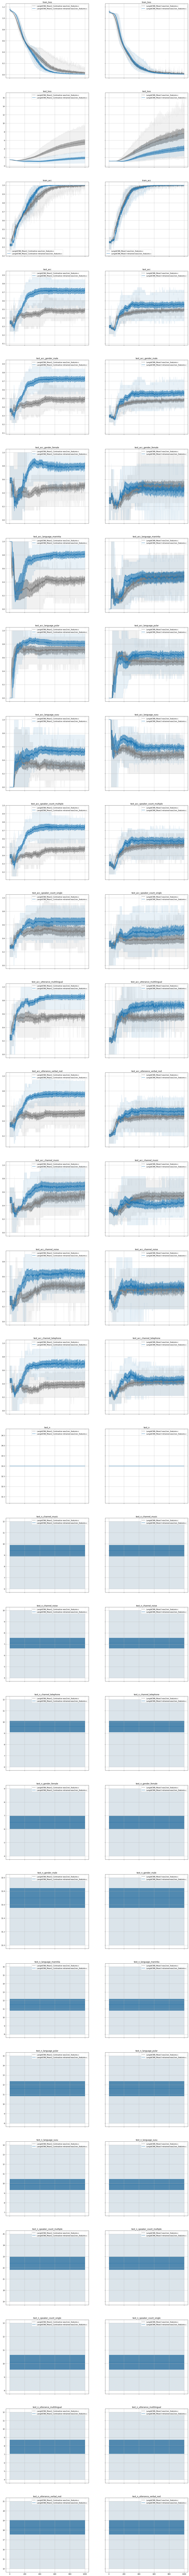

In [9]:
compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
plot_results(model_names, variables_and_sample_sizes, compared_features)

# Language Classification With Latent Features

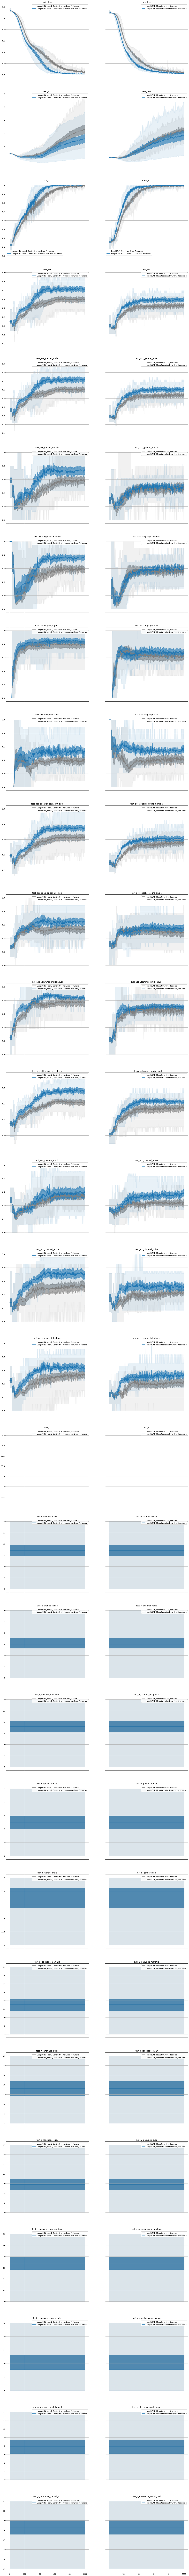

In [10]:
compared_features = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
plot_results(model_names, variables_and_sample_sizes, compared_features)

# Best epoch summaries

In [11]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [12]:
def plot_summary_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}
    
    series_means = {v:[] for v in variables}
    series_sems = {v:[] for v in variables}
    series_mins = {v:[] for v in variables}
    series_maxes = {v:[] for v in variables}
    
    series_labels = {v:[] for v in variables}
    
    for variable in variables:
        for feature_prefix in compared_features:
            sample_size = sample_sizes_by_variable[variable]
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
    
    for v in variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 20
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }

    
    #('test_acc_speaker_count_multiple', fold_count),
    #('test_acc_speaker_count_single', fold_count),
    
    
    #('test_acc_utterance_multilingual', fold_count),
    #('test_acc_utterance_verbal_nod', fold_count),
    
    
    #('test_acc_channel_music', fold_count),
    #('test_acc_channel_noise', fold_count),
    #('test_acc_channel_telephone', fold_count)
    

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    test_y_male_pos =(bar_width+bar_margin)*np.arange(label_count) + 3.5
    test_y_female_pos =(bar_width+bar_margin)*np.arange(label_count) + 4.5
    
    test_y_susu_pos =(bar_width+bar_margin)*np.arange(label_count) + 6
    test_y_maninka_pos =(bar_width+bar_margin)*np.arange(label_count) + 7
    test_y_pular_pos =(bar_width+bar_margin)*np.arange(label_count) + 8
    
    test_y_speaker_multi = (bar_width+bar_margin)*np.arange(label_count) + 9.5
    test_y_speaker_single = (bar_width+bar_margin)*np.arange(label_count) + 10.5
    
    test_y_utt_multilingual = (bar_width+bar_margin)*np.arange(label_count) + 12
    test_y_utt_verbal_nod = (bar_width+bar_margin)*np.arange(label_count) + 13
    
    test_y_channel_music = (bar_width+bar_margin)*np.arange(label_count) + 14.5
    test_y_channel_noise = (bar_width+bar_margin)*np.arange(label_count) + 15.5
    test_y_channel_telephone = (bar_width+bar_margin)*np.arange(label_count) + 16.5


    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    ax.barh(test_y_male_pos, series_means['test_acc_gender_male'], height=1, xerr=series_sems['test_acc_gender_male'], color=colors['male'], alpha=bias_alpha)
    ax.barh(test_y_female_pos, series_means['test_acc_gender_female'], height=1, xerr=series_sems['test_acc_gender_female'], color=colors['female'], alpha=bias_alpha)
    
    ax.barh(test_y_susu_pos, series_means['test_acc_language_susu'], height=1, xerr=series_sems['test_acc_language_susu'], color=colors['susu'], alpha=bias_alpha)
    ax.barh(test_y_maninka_pos, series_means['test_acc_language_maninka'], height=1, xerr=series_sems['test_acc_language_maninka'], color=colors['maninka'], alpha=bias_alpha)
    ax.barh(test_y_pular_pos, series_means['test_acc_language_pular'], height=1, xerr=series_sems['test_acc_language_pular'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_speaker_multi, series_means['test_acc_speaker_count_multiple'], height=1, xerr=series_sems['test_acc_speaker_count_multiple'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_speaker_single, series_means['test_acc_speaker_count_single'], height=1, xerr=series_sems['test_acc_speaker_count_single'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_utt_multilingual, series_means['test_acc_utterance_multilingual'], height=1, xerr=series_sems['test_acc_utterance_multilingual'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_utt_verbal_nod, series_means['test_acc_utterance_verbal_nod'], height=1, xerr=series_sems['test_acc_utterance_verbal_nod'], color=colors['pular'], alpha=bias_alpha)

    ax.barh(test_y_channel_music, series_means['test_acc_channel_music'], height=1, xerr=series_sems['test_acc_channel_music'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_noise, series_means['test_acc_channel_noise'], height=1, xerr=series_sems['test_acc_channel_noise'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_telephone, series_means['test_acc_channel_telephone'], height=1, xerr=series_sems['test_acc_channel_telephone'], color=colors['pular'], alpha=bias_alpha)

    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        

        
        ax.text(0.01, test_y_male_pos[i]-0.3, f"male ({series_means['test_n_gender_male'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_female_pos[i]-0.3, f"female ({series_means['test_n_gender_female'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_susu_pos[i]-0.3, f"susu ({series_means['test_n_language_susu'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_maninka_pos[i]-0.3, f"maninka ({series_means['test_n_language_maninka'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_pular_pos[i]-0.3, f"pular ({series_means['test_n_language_pular'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_speaker_multi[i]-0.3, f"multi speakers ({series_means['test_n_speaker_count_multiple'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_speaker_single[i]-0.3, f"single speaker ({series_means['test_n_speaker_count_single'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_utt_multilingual[i]-0.3, f"multi-lingual utt ({series_means['test_n_utterance_multilingual'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_utt_verbal_nod[i]-0.3, f"verbal nod utt ({series_means['test_n_utterance_verbal_nod'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_channel_music[i]-0.3, f"music ({series_means['test_n_channel_music'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_noise[i]-0.3, f"noise ({series_means['test_n_channel_noise'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_telephone[i]-0.3, f"telephone ({series_means['test_n_channel_telephone'][i]})", color='black', fontsize="small")
        
        
        ax.legend(["TRAIN", "TEST", "TEST (Male)", "TEST (Female)", "TEST (Susu)", "TEST (Maninka)", "TEST (Pular)"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n=10 folds) Language Identification Accuracies. Dropout p={dropout_rate}")
        ax.grid(True)

        
        


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_Mean2_Contrastive          0.275402         0.098886
1   OUR  Latent - CNN_Mean2_Contrastive          0.157684         0.038892

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_Mean2_Contrastive         2.106091        0.276037
1   OUR  Latent - CNN_Mean2_Contrastive         1.372735        0.210806

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_Mean2_Contrastive         0.876471        0.061134
1   OUR  Latent - CNN_Mean2_Contrastive         0.954902        0.021488

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_Mean2_Contrastive        0.663636       0.018408
1   OUR  Latent - CNN_Mean2_Contrastive        0.778788       0.026435

test_acc_gender_male_labels  test_acc_gender_male_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                    0.671472   
1   OUR  Latent - CNN_Mean2_Contrastive                    0.778730   

   test_acc_gender_male_sems  
0                   0.017604  
1                   0.026308

test_acc_gender_female_labels  test_acc_gender_female_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                      0.621508   
1   OUR  Latent - CNN_Mean2_Contrastive                      0.784563   

   test_acc_gender_female_sems  
0                     0.046468  
1                     0.060128

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                         0.705417   
1   OUR  Latent - CNN_Mean2_Contrastive                         0.804481   

   test_acc_language_maninka_sems  
0                        0.054506  
1                        0.030928

test_acc_language_pular_labels  test_acc_language_pular_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                       0.811675   
1   OUR  Latent - CNN_Mean2_Contrastive                       0.868935   

   test_acc_language_pular_sems  
0                      0.029098  
1                      0.031816

test_acc_language_susu_labels  test_acc_language_susu_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                      0.437128   
1   OUR  Latent - CNN_Mean2_Contrastive                      0.657908   

   test_acc_language_susu_sems  
0                     0.053508  
1                     0.049627

test_acc_speaker_count_multiple_labels  \
0   BSLN  Latent - CNN_Mean2_Contrastive   
1    OUR  Latent - CNN_Mean2_Contrastive   

   test_acc_speaker_count_multiple_means  test_acc_speaker_count_multiple_sems  
0                               0.705439                              0.021033  
1                               0.801560                              0.033816

test_acc_speaker_count_single_labels  test_acc_speaker_count_single_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                             0.588842   
1   OUR  Latent - CNN_Mean2_Contrastive                             0.724139   

   test_acc_speaker_count_single_sems  
0                            0.044104  
1                            0.046767

test_acc_utterance_multilingual_labels  \
0   BSLN  Latent - CNN_Mean2_Contrastive   
1    OUR  Latent - CNN_Mean2_Contrastive   

   test_acc_utterance_multilingual_means  test_acc_utterance_multilingual_sems  
0                               0.826667                              0.040108  
1                               0.909722                              0.026734

test_acc_utterance_verbal_nod_labels  test_acc_utterance_verbal_nod_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                             0.696884   
1   OUR  Latent - CNN_Mean2_Contrastive                             0.803521   

   test_acc_utterance_verbal_nod_sems  
0                            0.020463  
1                            0.025035

test_acc_channel_music_labels  test_acc_channel_music_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                      0.598510   
1   OUR  Latent - CNN_Mean2_Contrastive                      0.642222   

   test_acc_channel_music_sems  
0                     0.032764  
1                     0.077229

test_acc_channel_noise_labels  test_acc_channel_noise_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                      0.576667   
1   OUR  Latent - CNN_Mean2_Contrastive                      0.779286   

   test_acc_channel_noise_sems  
0                     0.040960  
1                     0.050812

test_acc_channel_telephone_labels  test_acc_channel_telephone_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                          0.626313   
1   OUR  Latent - CNN_Mean2_Contrastive                          0.741364   

   test_acc_channel_telephone_sems  
0                         0.025685  
1                         0.036201

test_n_labels  test_n_means  test_n_sems
0  BSLN  Latent - CNN_Mean2_Contrastive          33.0          0.0
1   OUR  Latent - CNN_Mean2_Contrastive          33.0          0.0

test_n_channel_music_labels  test_n_channel_music_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                         9.4   
1   OUR  Latent - CNN_Mean2_Contrastive                         9.4   

   test_n_channel_music_sems  
0                   0.493964  
1                   0.493964

test_n_channel_noise_labels  test_n_channel_noise_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                         7.1   
1   OUR  Latent - CNN_Mean2_Contrastive                         7.1   

   test_n_channel_noise_sems  
0                   0.457165  
1                   0.457165

test_n_channel_telephone_labels  test_n_channel_telephone_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                             9.6   
1   OUR  Latent - CNN_Mean2_Contrastive                             9.6   

   test_n_channel_telephone_sems  
0                       0.493964  
1                       0.493964

test_n_gender_female_labels  test_n_gender_female_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                         6.5   
1   OUR  Latent - CNN_Mean2_Contrastive                         6.5   

   test_n_gender_female_sems  
0                   0.474342  
1                   0.474342

test_n_gender_male_labels  test_n_gender_male_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                      31.7   
1   OUR  Latent - CNN_Mean2_Contrastive                      31.7   

   test_n_gender_male_sems  
0                 0.144914  
1                 0.144914

test_n_language_maninka_labels  test_n_language_maninka_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                           11.5   
1   OUR  Latent - CNN_Mean2_Contrastive                           11.5   

   test_n_language_maninka_sems  
0                      0.681909  
1                      0.681909

test_n_language_pular_labels  test_n_language_pular_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                         11.6   
1   OUR  Latent - CNN_Mean2_Contrastive                         11.6   

   test_n_language_pular_sems  
0                    0.764199  
1                    0.764199

test_n_language_susu_labels  test_n_language_susu_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                         9.9   
1   OUR  Latent - CNN_Mean2_Contrastive                         9.9   

   test_n_language_susu_sems  
0                   0.555878  
1                   0.555878

test_n_speaker_count_multiple_labels  test_n_speaker_count_multiple_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                                 22.4   
1   OUR  Latent - CNN_Mean2_Contrastive                                 22.4   

   test_n_speaker_count_multiple_sems  
0                             0.56921  
1                             0.56921

test_n_speaker_count_single_labels  test_n_speaker_count_single_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                               10.1   
1   OUR  Latent - CNN_Mean2_Contrastive                               10.1   

   test_n_speaker_count_single_sems  
0                          0.537587  
1                          0.537587

test_n_utterance_multilingual_labels  test_n_utterance_multilingual_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                                  7.9   
1   OUR  Latent - CNN_Mean2_Contrastive                                  7.9   

   test_n_utterance_multilingual_sems  
0                            0.817924  
1                            0.817924

test_n_utterance_verbal_nod_labels  test_n_utterance_verbal_nod_means  \
0  BSLN  Latent - CNN_Mean2_Contrastive                               18.3   
1   OUR  Latent - CNN_Mean2_Contrastive                               18.3   

   test_n_utterance_verbal_nod_sems  
0                          0.735527  
1                          0.735527

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - CNN_Mean2_Contrastive          0.437898         0.121325
1   OUR  Context - CNN_Mean2_Contrastive          0.306429         0.068740

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - CNN_Mean2_Contrastive         2.851901        0.516857
1   OUR  Context - CNN_Mean2_Contrastive         1.057963        0.104795

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - CNN_Mean2_Contrastive         0.792157        0.070272
1   OUR  Context - CNN_Mean2_Contrastive         0.884314        0.041820

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - CNN_Mean2_Contrastive        0.566667       0.017169
1   OUR  Context - CNN_Mean2_Contrastive        0.757576       0.029691

test_acc_gender_male_labels  test_acc_gender_male_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                    0.573387   
1   OUR  Context - CNN_Mean2_Contrastive                    0.749798   

   test_acc_gender_male_sems  
0                   0.020231  
1                   0.031356

test_acc_gender_female_labels  test_acc_gender_female_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                      0.527341   
1   OUR  Context - CNN_Mean2_Contrastive                      0.882540   

   test_acc_gender_female_sems  
0                     0.034848  
1                     0.033849

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                         0.625736   
1   OUR  Context - CNN_Mean2_Contrastive                         0.827381   

   test_acc_language_maninka_sems  
0                        0.065278  
1                        0.042794

test_acc_language_pular_labels  test_acc_language_pular_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                       0.749860   
1   OUR  Context - CNN_Mean2_Contrastive                       0.873617   

   test_acc_language_pular_sems  
0                      0.042202  
1                      0.034717

test_acc_language_susu_labels  test_acc_language_susu_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                      0.319524   
1   OUR  Context - CNN_Mean2_Contrastive                      0.561789   

   test_acc_language_susu_sems  
0                     0.078966  
1                     0.045548

test_acc_speaker_count_multiple_labels  \
0  BSLN  Context - CNN_Mean2_Contrastive   
1   OUR  Context - CNN_Mean2_Contrastive   

   test_acc_speaker_count_multiple_means  test_acc_speaker_count_multiple_sems  
0                               0.544933                              0.021294  
1                               0.783860                              0.024047

test_acc_speaker_count_single_labels  test_acc_speaker_count_single_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                             0.618232   
1   OUR  Context - CNN_Mean2_Contrastive                             0.674044   

   test_acc_speaker_count_single_sems  
0                            0.062599  
1                            0.058499

test_acc_utterance_multilingual_labels  \
0  BSLN  Context - CNN_Mean2_Contrastive   
1   OUR  Context - CNN_Mean2_Contrastive   

   test_acc_utterance_multilingual_means  test_acc_utterance_multilingual_sems  
0                               0.676667                              0.035839  
1                               0.883333                              0.035746

test_acc_utterance_verbal_nod_labels  test_acc_utterance_verbal_nod_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                             0.610822   
1   OUR  Context - CNN_Mean2_Contrastive                             0.810273   

   test_acc_utterance_verbal_nod_sems  
0                            0.038232  
1                            0.028897

test_acc_channel_music_labels  test_acc_channel_music_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                      0.562323   
1   OUR  Context - CNN_Mean2_Contrastive                      0.718207   

   test_acc_channel_music_sems  
0                     0.047721  
1                     0.038153

test_acc_channel_noise_labels  test_acc_channel_noise_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                      0.520595   
1   OUR  Context - CNN_Mean2_Contrastive                      0.705476   

   test_acc_channel_noise_sems  
0                     0.049880  
1                     0.046159

test_acc_channel_telephone_labels  test_acc_channel_telephone_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                          0.482576   
1   OUR  Context - CNN_Mean2_Contrastive                          0.772071   

   test_acc_channel_telephone_sems  
0                         0.039871  
1                         0.045984

test_n_labels  test_n_means  test_n_sems
0  BSLN  Context - CNN_Mean2_Contrastive          33.0          0.0
1   OUR  Context - CNN_Mean2_Contrastive          33.0          0.0

test_n_channel_music_labels  test_n_channel_music_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                         9.4   
1   OUR  Context - CNN_Mean2_Contrastive                         9.4   

   test_n_channel_music_sems  
0                   0.493964  
1                   0.493964

test_n_channel_noise_labels  test_n_channel_noise_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                         7.1   
1   OUR  Context - CNN_Mean2_Contrastive                         7.1   

   test_n_channel_noise_sems  
0                   0.457165  
1                   0.457165

test_n_channel_telephone_labels  test_n_channel_telephone_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                             9.6   
1   OUR  Context - CNN_Mean2_Contrastive                             9.6   

   test_n_channel_telephone_sems  
0                       0.493964  
1                       0.493964

test_n_gender_female_labels  test_n_gender_female_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                         6.5   
1   OUR  Context - CNN_Mean2_Contrastive                         6.5   

   test_n_gender_female_sems  
0                   0.474342  
1                   0.474342

test_n_gender_male_labels  test_n_gender_male_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                      31.7   
1   OUR  Context - CNN_Mean2_Contrastive                      31.7   

   test_n_gender_male_sems  
0                 0.144914  
1                 0.144914

test_n_language_maninka_labels  test_n_language_maninka_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                           11.5   
1   OUR  Context - CNN_Mean2_Contrastive                           11.5   

   test_n_language_maninka_sems  
0                      0.681909  
1                      0.681909

test_n_language_pular_labels  test_n_language_pular_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                         11.6   
1   OUR  Context - CNN_Mean2_Contrastive                         11.6   

   test_n_language_pular_sems  
0                    0.764199  
1                    0.764199

test_n_language_susu_labels  test_n_language_susu_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                         9.9   
1   OUR  Context - CNN_Mean2_Contrastive                         9.9   

   test_n_language_susu_sems  
0                   0.555878  
1                   0.555878

test_n_speaker_count_multiple_labels  test_n_speaker_count_multiple_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                                 22.4   
1   OUR  Context - CNN_Mean2_Contrastive                                 22.4   

   test_n_speaker_count_multiple_sems  
0                             0.56921  
1                             0.56921

test_n_speaker_count_single_labels  test_n_speaker_count_single_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                               10.1   
1   OUR  Context - CNN_Mean2_Contrastive                               10.1   

   test_n_speaker_count_single_sems  
0                          0.537587  
1                          0.537587

test_n_utterance_multilingual_labels  test_n_utterance_multilingual_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                                  7.9   
1   OUR  Context - CNN_Mean2_Contrastive                                  7.9   

   test_n_utterance_multilingual_sems  
0                            0.817924  
1                            0.817924

test_n_utterance_verbal_nod_labels  test_n_utterance_verbal_nod_means  \
0  BSLN  Context - CNN_Mean2_Contrastive                               18.3   
1   OUR  Context - CNN_Mean2_Contrastive                               18.3   

   test_n_utterance_verbal_nod_sems  
0                          0.735527  
1                          0.735527

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_Mean3          0.225228         0.063578
1   OUR  Latent - CNN_Mean3          0.190426         0.039618

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_Mean3         2.089931        0.231643
1   OUR  Latent - CNN_Mean3         1.658246        0.249746

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_Mean3         0.913725        0.035963
1   OUR  Latent - CNN_Mean3         0.962745        0.013139

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_Mean3        0.596970       0.021873
1   OUR  Latent - CNN_Mean3        0.642424       0.020463

test_acc_gender_male_labels  test_acc_gender_male_means  \
0    BSLN  Latent - CNN_Mean3                    0.601915   
1     OUR  Latent - CNN_Mean3                    0.648992   

   test_acc_gender_male_sems  
0                   0.021848  
1                   0.022157

test_acc_gender_female_labels  test_acc_gender_female_means  \
0      BSLN  Latent - CNN_Mean3                      0.520992   
1       OUR  Latent - CNN_Mean3                      0.510119   

   test_acc_gender_female_sems  
0                     0.034436  
1                     0.035796

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0         BSLN  Latent - CNN_Mean3                         0.611023   
1          OUR  Latent - CNN_Mean3                         0.630287   

   test_acc_language_maninka_sems  
0                        0.065697  
1                        0.042859

test_acc_language_pular_labels  test_acc_language_pular_means  \
0       BSLN  Latent - CNN_Mean3                       0.723781   
1        OUR  Latent - CNN_Mean3                       0.728614   

   test_acc_language_pular_sems  
0                      0.055464  
1                      0.064991

test_acc_language_susu_labels  test_acc_language_susu_means  \
0      BSLN  Latent - CNN_Mean3                      0.462020   
1       OUR  Latent - CNN_Mean3                      0.624329   

   test_acc_language_susu_sems  
0                     0.067080  
1                     0.060511

test_acc_speaker_count_multiple_labels  \
0               BSLN  Latent - CNN_Mean3   
1                OUR  Latent - CNN_Mean3   

   test_acc_speaker_count_multiple_means  test_acc_speaker_count_multiple_sems  
0                               0.605401                              0.025210  
1                               0.657311                              0.021497

test_acc_speaker_count_single_labels  test_acc_speaker_count_single_means  \
0             BSLN  Latent - CNN_Mean3                             0.584237   
1              OUR  Latent - CNN_Mean3                             0.601074   

   test_acc_speaker_count_single_sems  
0                            0.058811  
1                            0.044912

test_acc_utterance_multilingual_labels  \
0               BSLN  Latent - CNN_Mean3   
1                OUR  Latent - CNN_Mean3   

   test_acc_utterance_multilingual_means  test_acc_utterance_multilingual_sems  
0                               0.727222                              0.051146  
1                               0.730000                              0.029860

test_acc_utterance_verbal_nod_labels  test_acc_utterance_verbal_nod_means  \
0             BSLN  Latent - CNN_Mean3                             0.603917   
1              OUR  Latent - CNN_Mean3                             0.664359   

   test_acc_utterance_verbal_nod_sems  
0                            0.035813  
1                            0.022727

test_acc_channel_music_labels  test_acc_channel_music_means  \
0      BSLN  Latent - CNN_Mean3                      0.533788   
1       OUR  Latent - CNN_Mean3                      0.622247   

   test_acc_channel_music_sems  
0                     0.029091  
1                     0.042993

test_acc_channel_noise_labels  test_acc_channel_noise_means  \
0      BSLN  Latent - CNN_Mean3                      0.505238   
1       OUR  Latent - CNN_Mean3                      0.602619   

   test_acc_channel_noise_sems  
0                     0.038032  
1                     0.047215

test_acc_channel_telephone_labels  test_acc_channel_telephone_means  \
0          BSLN  Latent - CNN_Mean3                          0.465000   
1           OUR  Latent - CNN_Mean3                          0.576313   

   test_acc_channel_telephone_sems  
0                         0.057687  
1                         0.038903

test_n_labels  test_n_means  test_n_sems
0  BSLN  Latent - CNN_Mean3          33.0          0.0
1   OUR  Latent - CNN_Mean3          33.0          0.0

test_n_channel_music_labels  test_n_channel_music_means  \
0    BSLN  Latent - CNN_Mean3                         9.4   
1     OUR  Latent - CNN_Mean3                         9.4   

   test_n_channel_music_sems  
0                   0.493964  
1                   0.493964

test_n_channel_noise_labels  test_n_channel_noise_means  \
0    BSLN  Latent - CNN_Mean3                         7.1   
1     OUR  Latent - CNN_Mean3                         7.1   

   test_n_channel_noise_sems  
0                   0.457165  
1                   0.457165

test_n_channel_telephone_labels  test_n_channel_telephone_means  \
0        BSLN  Latent - CNN_Mean3                             9.6   
1         OUR  Latent - CNN_Mean3                             9.6   

   test_n_channel_telephone_sems  
0                       0.493964  
1                       0.493964

test_n_gender_female_labels  test_n_gender_female_means  \
0    BSLN  Latent - CNN_Mean3                         6.5   
1     OUR  Latent - CNN_Mean3                         6.5   

   test_n_gender_female_sems  
0                   0.474342  
1                   0.474342

test_n_gender_male_labels  test_n_gender_male_means  test_n_gender_male_sems
0  BSLN  Latent - CNN_Mean3                      31.7                 0.144914
1   OUR  Latent - CNN_Mean3                      31.7                 0.144914

test_n_language_maninka_labels  test_n_language_maninka_means  \
0       BSLN  Latent - CNN_Mean3                           11.5   
1        OUR  Latent - CNN_Mean3                           11.5   

   test_n_language_maninka_sems  
0                      0.681909  
1                      0.681909

test_n_language_pular_labels  test_n_language_pular_means  \
0     BSLN  Latent - CNN_Mean3                         11.6   
1      OUR  Latent - CNN_Mean3                         11.6   

   test_n_language_pular_sems  
0                    0.764199  
1                    0.764199

test_n_language_susu_labels  test_n_language_susu_means  \
0    BSLN  Latent - CNN_Mean3                         9.9   
1     OUR  Latent - CNN_Mean3                         9.9   

   test_n_language_susu_sems  
0                   0.555878  
1                   0.555878

test_n_speaker_count_multiple_labels  test_n_speaker_count_multiple_means  \
0             BSLN  Latent - CNN_Mean3                                 22.4   
1              OUR  Latent - CNN_Mean3                                 22.4   

   test_n_speaker_count_multiple_sems  
0                             0.56921  
1                             0.56921

test_n_speaker_count_single_labels  test_n_speaker_count_single_means  \
0           BSLN  Latent - CNN_Mean3                               10.1   
1            OUR  Latent - CNN_Mean3                               10.1   

   test_n_speaker_count_single_sems  
0                          0.537587  
1                          0.537587

test_n_utterance_multilingual_labels  test_n_utterance_multilingual_means  \
0             BSLN  Latent - CNN_Mean3                                  7.9   
1              OUR  Latent - CNN_Mean3                                  7.9   

   test_n_utterance_multilingual_sems  
0                            0.817924  
1                            0.817924

test_n_utterance_verbal_nod_labels  test_n_utterance_verbal_nod_means  \
0           BSLN  Latent - CNN_Mean3                               18.3   
1            OUR  Latent - CNN_Mean3                               18.3   

   test_n_utterance_verbal_nod_sems  
0                          0.735527  
1                          0.735527

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - CNN_Mean3          0.219995         0.048299
1   OUR  Context - CNN_Mean3          0.284900         0.058334

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - CNN_Mean3         4.473213        1.361749
1   OUR  Context - CNN_Mean3         1.734219        0.251162

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - CNN_Mean3         0.939216        0.019101
1   OUR  Context - CNN_Mean3         0.919608        0.027091

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - CNN_Mean3        0.542424       0.015121
1   OUR  Context - CNN_Mean3        0.630303       0.026348

test_acc_gender_male_labels  test_acc_gender_male_means  \
0   BSLN  Context - CNN_Mean3                    0.532964   
1    OUR  Context - CNN_Mean3                    0.630242   

   test_acc_gender_male_sems  
0                   0.014923  
1                   0.025542

test_acc_gender_female_labels  test_acc_gender_female_means  \
0     BSLN  Context - CNN_Mean3                       0.51500   
1      OUR  Context - CNN_Mean3                       0.57627   

   test_acc_gender_female_sems  
0                      0.06213  
1                      0.05703

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0        BSLN  Context - CNN_Mean3                         0.509724   
1         OUR  Context - CNN_Mean3                         0.550049   

   test_acc_language_maninka_sems  
0                        0.056174  
1                        0.064719

test_acc_language_pular_labels  test_acc_language_pular_means  \
0      BSLN  Context - CNN_Mean3                       0.621111   
1       OUR  Context - CNN_Mean3                       0.692980   

   test_acc_language_pular_sems  
0                      0.063845  
1                      0.043589

test_acc_language_susu_labels  test_acc_language_susu_means  \
0     BSLN  Context - CNN_Mean3                      0.534098   
1      OUR  Context - CNN_Mean3                      0.704733   

   test_acc_language_susu_sems  
0                     0.059362  
1                     0.047611

test_acc_speaker_count_multiple_labels  \
0              BSLN  Context - CNN_Mean3   
1               OUR  Context - CNN_Mean3   

   test_acc_speaker_count_multiple_means  test_acc_speaker_count_multiple_sems  
0                               0.575811                              0.025951  
1                               0.659649                              0.024025

test_acc_speaker_count_single_labels  test_acc_speaker_count_single_means  \
0            BSLN  Context - CNN_Mean3                             0.449528   
1             OUR  Context - CNN_Mean3                             0.572539   

   test_acc_speaker_count_single_sems  
0                            0.068399  
1                            0.064193

test_acc_utterance_multilingual_labels  \
0              BSLN  Context - CNN_Mean3   
1               OUR  Context - CNN_Mean3   

   test_acc_utterance_multilingual_means  test_acc_utterance_multilingual_sems  
0                               0.659167                              0.044666  
1                               0.804167                              0.047077

test_acc_utterance_verbal_nod_labels  test_acc_utterance_verbal_nod_means  \
0            BSLN  Context - CNN_Mean3                             0.514497   
1             OUR  Context - CNN_Mean3                             0.610906   

   test_acc_utterance_verbal_nod_sems  
0                            0.025036  
1                            0.033894

test_acc_channel_music_labels  test_acc_channel_music_means  \
0     BSLN  Context - CNN_Mean3                      0.592449   
1      OUR  Context - CNN_Mean3                      0.518359   

   test_acc_channel_music_sems  
0                     0.055762  
1                     0.059246

test_acc_channel_noise_labels  test_acc_channel_noise_means  \
0     BSLN  Context - CNN_Mean3                      0.463095   
1      OUR  Context - CNN_Mean3                      0.602738   

   test_acc_channel_noise_sems  
0                     0.051685  
1                     0.047867

test_acc_channel_telephone_labels  test_acc_channel_telephone_means  \
0         BSLN  Context - CNN_Mean3                          0.455556   
1          OUR  Context - CNN_Mean3                          0.598182   

   test_acc_channel_telephone_sems  
0                         0.030133  
1                         0.045924

test_n_labels  test_n_means  test_n_sems
0  BSLN  Context - CNN_Mean3          33.0          0.0
1   OUR  Context - CNN_Mean3          33.0          0.0

test_n_channel_music_labels  test_n_channel_music_means  \
0   BSLN  Context - CNN_Mean3                         9.4   
1    OUR  Context - CNN_Mean3                         9.4   

   test_n_channel_music_sems  
0                   0.493964  
1                   0.493964

test_n_channel_noise_labels  test_n_channel_noise_means  \
0   BSLN  Context - CNN_Mean3                         7.1   
1    OUR  Context - CNN_Mean3                         7.1   

   test_n_channel_noise_sems  
0                   0.457165  
1                   0.457165

test_n_channel_telephone_labels  test_n_channel_telephone_means  \
0       BSLN  Context - CNN_Mean3                             9.6   
1        OUR  Context - CNN_Mean3                             9.6   

   test_n_channel_telephone_sems  
0                       0.493964  
1                       0.493964

test_n_gender_female_labels  test_n_gender_female_means  \
0   BSLN  Context - CNN_Mean3                         6.5   
1    OUR  Context - CNN_Mean3                         6.5   

   test_n_gender_female_sems  
0                   0.474342  
1                   0.474342

test_n_gender_male_labels  test_n_gender_male_means  \
0  BSLN  Context - CNN_Mean3                      31.7   
1   OUR  Context - CNN_Mean3                      31.7   

   test_n_gender_male_sems  
0                 0.144914  
1                 0.144914

test_n_language_maninka_labels  test_n_language_maninka_means  \
0      BSLN  Context - CNN_Mean3                           11.5   
1       OUR  Context - CNN_Mean3                           11.5   

   test_n_language_maninka_sems  
0                      0.681909  
1                      0.681909

test_n_language_pular_labels  test_n_language_pular_means  \
0    BSLN  Context - CNN_Mean3                         11.6   
1     OUR  Context - CNN_Mean3                         11.6   

   test_n_language_pular_sems  
0                    0.764199  
1                    0.764199

test_n_language_susu_labels  test_n_language_susu_means  \
0   BSLN  Context - CNN_Mean3                         9.9   
1    OUR  Context - CNN_Mean3                         9.9   

   test_n_language_susu_sems  
0                   0.555878  
1                   0.555878

test_n_speaker_count_multiple_labels  test_n_speaker_count_multiple_means  \
0            BSLN  Context - CNN_Mean3                                 22.4   
1             OUR  Context - CNN_Mean3                                 22.4   

   test_n_speaker_count_multiple_sems  
0                             0.56921  
1                             0.56921

test_n_speaker_count_single_labels  test_n_speaker_count_single_means  \
0          BSLN  Context - CNN_Mean3                               10.1   
1           OUR  Context - CNN_Mean3                               10.1   

   test_n_speaker_count_single_sems  
0                          0.537587  
1                          0.537587

test_n_utterance_multilingual_labels  test_n_utterance_multilingual_means  \
0            BSLN  Context - CNN_Mean3                                  7.9   
1             OUR  Context - CNN_Mean3                                  7.9   

   test_n_utterance_multilingual_sems  
0                            0.817924  
1                            0.817924

test_n_utterance_verbal_nod_labels  test_n_utterance_verbal_nod_means  \
0          BSLN  Context - CNN_Mean3                               18.3   
1           OUR  Context - CNN_Mean3                               18.3   

   test_n_utterance_verbal_nod_sems  
0                          0.735527  
1                          0.735527

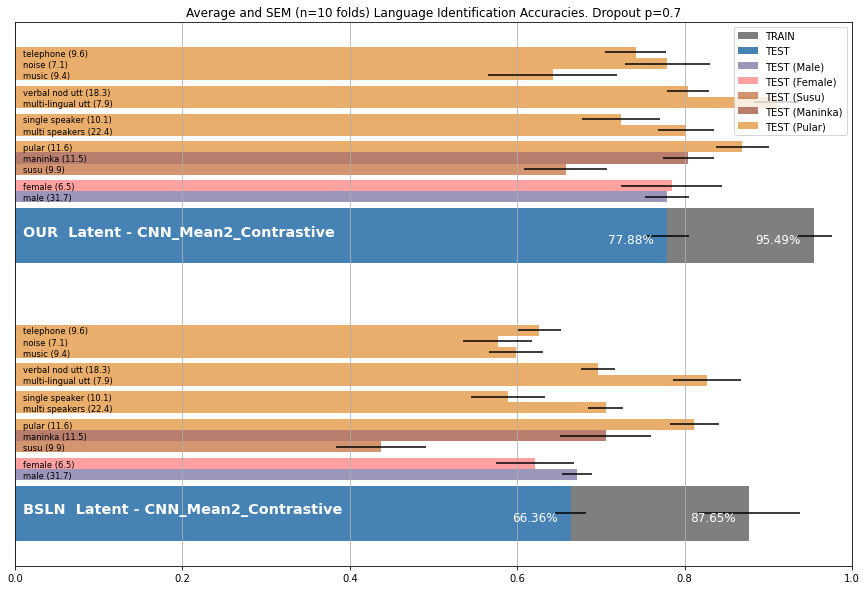

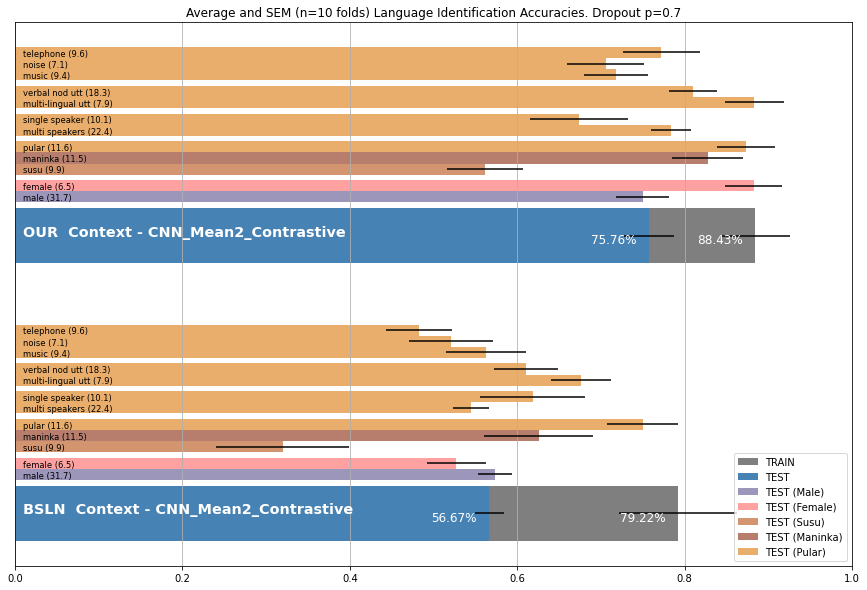

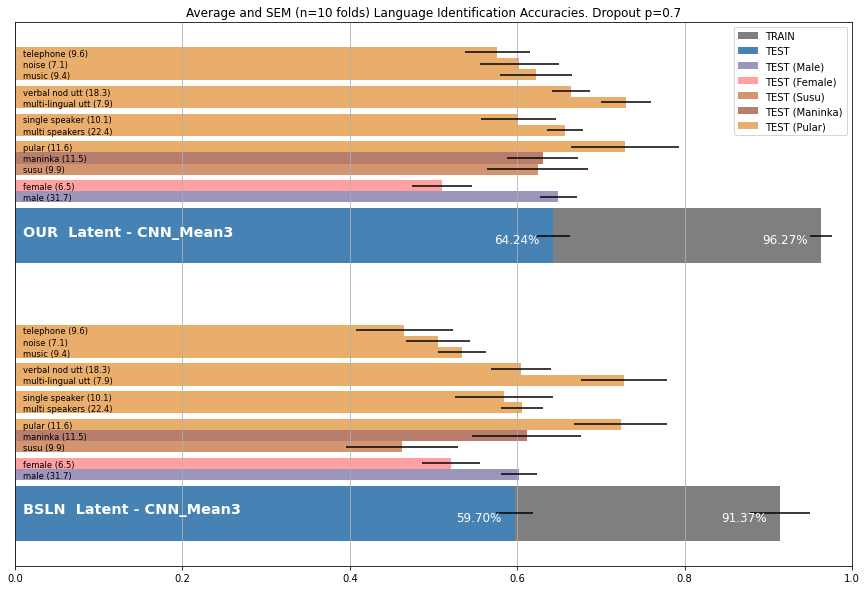

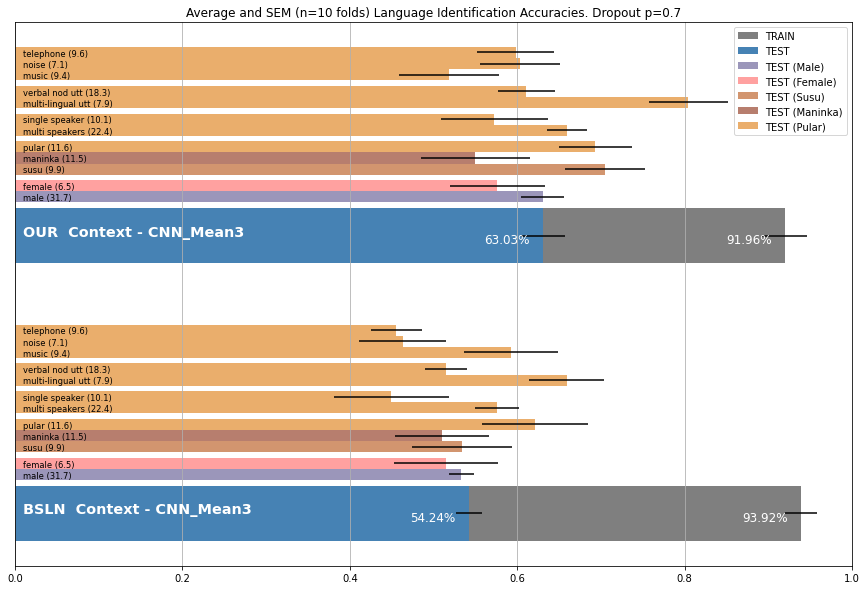

In [13]:
compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
compared_features_ctx = ['wav2vec_features-c', 'retrained-wav2vec_features-c']

for model_name in model_names:
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_latent)
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_ctx)
